<a href="https://colab.research.google.com/github/hritiksth764/END-COURSE-SESSION-4.0-/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:


# install huggingface libraries
! pip install pytorch-pretrained-bert==0.6.2 pytorch-nlp==0.5.0 pytorch_transformers==1.2.0



In [7]:
"/content/drive/MyDrive/Colab Notebooks/train-v2.0.json"

'/content/drive/MyDrive/Colab Notebooks/train-v2.0.json'

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm.auto import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'


--2022-01-29 13:34:54--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12493 (12K) [text/plain]
Saving to: ‘utils_squad_evaluate.py’

utils_squad_evaluat 100%[===================>]  12.20K  --.-KB/s    in 0s      

2022-01-29 13:34:54 (111 MB/s) - ‘utils_squad_evaluate.py’ saved [12493/12493]



In [6]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'


--2022-01-29 13:34:58--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py’

utils_squad.py      100%[===================>]  40.56K  --.-KB/s    in 0s      

2022-01-29 13:34:58 (160 MB/s) - ‘utils_squad.py’ saved [41529/41529]



In [7]:
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'


--2022-01-29 13:35:02--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  --.-KB/s    in 0.1s    

2022-01-29 13:35:02 (380 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]



In [ ]:
!pwd

In [8]:
from utils_squad import (read_squad_examples, convert_examples_to_features,RawResult, write_predictions,RawResultExtended, write_predictions_extended)

from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve


In [9]:
input_file = '/content/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)



In [10]:
examples = examples[:20000]

In [11]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()


,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [12]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
7510,56dc591114d3a41400c267fd,What is the term for something that lists the ...,"[Whereas, a, genome, sequence, lists, the, ord...",genome map,15,16,False
7511,56dc591114d3a41400c267fe,Which group was created to generate a genome m...,"[Whereas, a, genome, sequence, lists, the, ord...",The Human Genome Project,37,40,False
7512,56dc591114d3a41400c267ff,Whose genome map greatly aided the Human Genom...,"[Whereas, a, genome, sequence, lists, the, ord...",Jean Weissenbach,66,67,False
7513,56dc591114d3a41400c26800,Where did Weissenbach and his colleagues work?,"[Whereas, a, genome, sequence, lists, the, ord...",Genoscope,73,73,False
7514,5a593aad3e1742001a15d030,What does a genome map list the order of?,"[Whereas, a, genome, sequence, lists, the, ord...",,-1,-1,True
7515,5a593aad3e1742001a15d031,What does a genome sequence identify?,"[Whereas, a, genome, sequence, lists, the, ord...",,-1,-1,True
7516,5a593aad3e1742001a15d032,What is a Genoscope less detailed than?,"[Whereas, a, genome, sequence, lists, the, ord...",,-1,-1,True
7517,5a593aad3e1742001a15d033,What does a Genoscope help a scientist do?,"[Whereas, a, genome, sequence, lists, the, ord...",,-1,-1,True
7518,5a593aad3e1742001a15d034,Why was the Genoscope created?,"[Whereas, a, genome, sequence, lists, the, ord...",,-1,-1,True


In [13]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))


In [14]:
print_squad_sample(train_data)

CONTEXT: 
Nick Fradiani won the season, defeating Clark Beckham. By winning, Fradiani became the first
winner from the Northeast region. Fradiani released "Beautiful Life" as his coronation single while
Beckham released "Champion". Jax, the third place finalist, also released a single called "Forcefield".
QUESTION:                                                                                            ANSWER:
Who won American Idols fourteenth season?                                                            Nick Fradiani
Who came in second on American Idol in season 14?                                                    Clark Beckham
Who came in third on American Idol in season 14?                                                     Jax
What was the name of Nick Fradianis victory song?                                                    Beautiful Life
What song did Jax release after coming in third on American Idol?                                    Forcefield
Who won this season o

In [15]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
14204,56dfc1cc7aa994140058e135,What magazine did Bell found alongside Hubbard?,"[In, partnership, with, Gardiner, Greene, Hubb...",Science,11,11,False,149,47
4666,56d097fb234ae51400d9c3ae,What brought attention to solar technologies i...,"[The, 1973, oil, embargo, and, 1979, energy, c...",The 1973 oil embargo and 1979 energy crisis,0,7,False,72,58
323,56bea5f23aeaaa14008c91a1,"As of April 2014, how many albums have Jay Z a...","[Beyoncé, is, believed, to, have, first, start...",300 million,78,79,False,160,71
13776,5acdfd2f32bba1001ae49959,What was Soviet Russia not called as of 1937?,"[The, final, name, for, the, republic, during,...",,-1,-1,True,27,45
7357,56db756ce7c41114004b513d,Who was arrested on April 26 for posting an on...,"[A, Macau, resident, was, arrested, on, April,...",A Macau resident,0,2,False,77,59


In [16]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))


Percentage of context's less than max_seq_length = 98.75%


In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 4405553.95B/s]


In [18]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16


In [19]:
cached_features_file = '/content/cache_train'

In [20]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)



In [21]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [22]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)



In [23]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)


In [24]:
import glob
checkpoints = sorted(glob.glob('/content/checkpoint*-[0-9]*'))



In [25]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [26]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/content/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()


100%|██████████| 440473133/440473133 [00:31<00:00, 13818718.75B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [27]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0013,  0.0142, -0.0184,  ...,  0.0142, -0.0181,  0.0064],
        [ 0.0056, -0.0160,  0.0017,  ..., -0.0066,  0.0167,  0.0065]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [28]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)


In [29]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)


***** Running training *****
  Num examples = 21615
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 1350


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1350 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 1.5936588881015779
Saving model checkpoint to /content/checkpoint-1000


In [30]:
output_dir = '/content/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))

In [31]:
train_loss_set_ckpt = torch.load('/content/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)


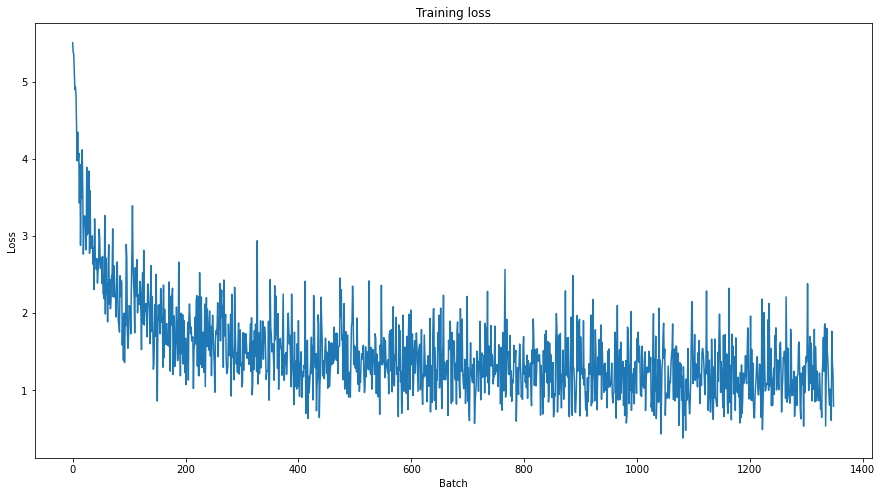

In [32]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()


In [34]:
input_file = '/content/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)


In [35]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)


In [36]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)


In [37]:
output_prediction_file = "/content/predictions.json"
output_nbest_file = "/content/nbest_predictions.json"
output_null_log_odds_file = "/content/null_odds.json"
output_dir = "/content/predict_results"

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [38]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating:   0%|          | 0/850 [00:00<?, ?it/s]

{
  "exact": 51.149667312389454,
  "f1": 54.660354989342096,
  "total": 11873,
  "HasAns_exact": 54.50404858299595,
  "HasAns_f1": 61.53549169845772,
  "HasAns_total": 5928,
  "NoAns_exact": 47.80487804878049,
  "NoAns_f1": 47.80487804878049,
  "NoAns_total": 5945,
  "best_exact": 52.6909795333951,
  "best_exact_thresh": -1.3084044456481934,
  "best_f1": 55.52708158152856,
  "best_f1_thresh": -0.5955591201782227
}


In [39]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 51.149667312389454}, {'f1': 54.660354989342096}, {'total': 11873}, {'HasAns_exact': 54.50404858299595}, {'HasAns_f1': 61.53549169845772}, {'HasAns_total': 5928}, {'NoAns_exact': 47.80487804878049}, {'NoAns_f1': 47.80487804878049}, {'NoAns_total': 5945}, {'best_exact': 52.6909795333951}, {'best_exact_thresh': -1.3084044456481934}, {'best_f1': 55.52708158152856}, {'best_f1_thresh': -0.5955591201782227}]


In [40]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [41]:
with open(output_prediction_file) as f:
    lines = f.readlines() 

print("Document: ", (" ".join(val_examples[0].__dict__["doc_tokens"])))
print("\n\n")
for index, each in enumerate(val_examples[:5]):
  print(f"question_text: {each.question_text} \nPredicted Answer: {(lines[index+1].split(':')[1])}")

Document:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.



question_text: In what country is Normandy located? 
Predicted Answer:  "France",

question_text: When were the Normans in Normandy? 
Predicted Answer:  "10th and 11th centuries",

question_text: From which countries did the Norse originate? 
